In [64]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pyspark.sql.functions import split, udf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from matplotlib import pyplot as plt
import pandas as pd

In [65]:
spark = SparkSession.builder \
    .master("spark://10.129.6.139:7077") \
    .appName("Analysis") \
    .getOrCreate()

In [66]:
df = spark.read.csv("Data/Traffic_Violations_preprocessed.csv", header=True)

In [67]:
df.printSchema()

root
 |-- Belts: string (nullable = true)
 |-- Personal Injury: string (nullable = true)
 |-- Property Damage: string (nullable = true)
 |-- Fatal: string (nullable = true)
 |-- HAZMAT: string (nullable = true)
 |-- Commercial Vehicle: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Work Zone: string (nullable = true)
 |-- VehicleType: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Violation Type: string (nullable = true)
 |-- Contributed To Accident: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Datetime: string (nullable = true)



In [68]:
df.take(1)

[Row(Belts='0', Personal Injury='0', Property Damage='0', Fatal='0', HAZMAT='0', Commercial Vehicle='0', Alcohol='0', Work Zone='0', VehicleType='Light', Year='2013.0', Color='RED', Violation Type='Warning', Contributed To Accident='0', Race='HISPANIC', Gender='1', Datetime='2016-07-08T02:10:00.000+02:00')]

## Stats

**Add more columns**

In [7]:
def date2year(value):
    return value.split('-')[0]


def date2month(value):
    return value.split('-')[1]

udf_to_year = udf(date2year, StringType())
udf_to_month = udf(date2month, StringType())

df = df.withColumn('Year', udf_to_year("Datetime")).withColumn('Month', udf_to_month("Datetime"))

In [75]:
df.take(1)

[Row(Belts='0', Personal Injury='0', Property Damage='0', Fatal='0', HAZMAT='0', Commercial Vehicle='0', Alcohol='0', Work Zone='0', VehicleType='Light', Year='2013.0', Color='RED', Violation Type='Warning', Contributed To Accident='0', Race='HISPANIC', Gender='1', Datetime='2016-07-08T02:10:00.000+02:00')]

In [76]:
df.groupBy('Year', 'Gender').count().show()

+------+------+-----+
|  Year|Gender|count|
+------+------+-----+
|1966.0|     0|    9|
|2013.0|  null|   41|
|2010.0|     1|29434|
|2009.0|     1|25327|
|1964.0|     0|    2|
|2015.0|     1|16169|
|1986.0|     1|  707|
|2006.0|     1|42985|
|2006.0|  null|   74|
|1996.0|     1|14282|
|1997.0|     0| 5801|
|2016.0|     0| 3665|
|1975.0|     1|   39|
|1996.0|  null|   26|
|2010.0|     0|21002|
|1992.0|  null|    9|
|1964.0|     1|   18|
|2015.0|     0| 9219|
|1995.0|     1|13126|
|1982.0|     1|  123|
+------+------+-----+
only showing top 20 rows



**Rename some columns**

In [77]:
dropped = df.withColumnRenamed("Date of Stop", "Date")\
                 .withColumnRenamed("Time Of Stop", "Time")

## Models

In [78]:
INTERESTED_FIELDS = ['Gender', 'Alcohol', 'Belts', 'Fatal', 'Personal Injury', 'Property Damage', 'Contributed To Accident']

df = df[INTERESTED_FIELDS]

**Drop rows with null values**

In [79]:
dropped = df.na.drop(how='any')

**Create label column**

If all _Personal Injury_, _Property Damage_, _Fatal_, _Contributed To Accident_ = 0 -> Label = 0. Otherwise, 1

In [80]:
def label_define(a,b,c,d):
    if a =='0' and b =='0' and c =='0' and d =='0':
        return 0
    return 1
udf_label_def = udf(label_define, StringType())

dropped = dropped.withColumn('label',  udf_label_def(dropped['Fatal'], dropped['Personal Injury'], dropped['Property Damage'], dropped['Contributed To Accident']))

In [81]:
dropped.groupby('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    0|976788|
|    1| 40703|
+-----+------+



In [82]:
dropped.groupby('Contributed To Accident').count().show()

+-----------------------+------+
|Contributed To Accident| count|
+-----------------------+------+
|                      0|993873|
|                      1| 23618|
+-----------------------+------+



In [83]:
dropped.take(1)

[Row(Gender='1', Alcohol='0', Belts='0', Fatal='0', Personal Injury='0', Property Damage='0', Contributed To Accident='0', label='0')]

**DECISION TREE**

In [84]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [85]:
# feats = ['Gender', 'Alcohol', 'Belts', 'label', 'Race', 'Commercial Vehicle', 'Personal Injury', 'Property Damage', 'Fatal', 'Contributed To Accident' ]

feats = ['Gender', 'Alcohol', 'Belts', 'label']

In [86]:
data = dropped[feats]

In [87]:
# data.show(1)

In [88]:
data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Belts: string (nullable = true)
 |-- label: string (nullable = true)



In [89]:
data = data.withColumn('Gender_INT', data.Gender.cast(IntegerType())).withColumn('Alcohol_INT', data.Alcohol.cast(IntegerType())).withColumn('Belts_INT', data.Belts.cast(IntegerType()))

In [90]:
data = data.withColumn('label_INT', data.label.cast(IntegerType())).drop('label')

In [91]:
data = data.withColumn('label', data.label_INT)

In [92]:
# data = data.withColumn('fatal_INT', data.Fatal.cast(IntegerType())).withColumn('pd_INT', data['Property Damage'].cast(IntegerType())).withColumn('cta_INT', data['Contributed To Accident'].cast(IntegerType()))

# print(data.corr('Gender_INT',"label_INT"))
# print(data.corr('Gender_INT',"pi_INT"))
# print(data.corr('Gender_INT',"fatal_INT"))
# print(data.corr('Gender_INT',"pd_INT"))
# print(data.corr('Gender_INT',"cta_INT"))

# print(data.corr('Belts_INT',"label_INT"))
# print(data.corr('Belts_INT',"pi_INT"))
# print(data.corr('Belts_INT',"fatal_INT"))
# print(data.corr('Belts_INT',"pd_INT"))
# print(data.corr('Belts_INT',"cta_INT"))

# print(data.corr('Alcohol_INT',"label_INT"))
# print(data.corr('Alcohol_INT',"pi_INT"))
# print(data.corr('Alcohol_INT',"fatal_INT"))
# print(data.corr('Alcohol_INT',"pd_INT"))
# print(data.corr('Alcohol_INT',"cta_INT"))

# print(data.corr('Commercial_Vehicle_INT',"label_INT"))
# print(data.corr('Commercial_Vehicle_INT',"pi_INT"))
# print(data.corr('Commercial_Vehicle_INT',"fatal_INT"))
# print(data.corr('Commercial_Vehicle_INT',"pd_INT"))
# print(data.corr('Commercial_Vehicle_INT',"cta_INT"))

# print(data.corr('pi_INT',"label_INT"))
# print(data.corr('fatal_INT',"label_INT"))
# print(data.corr('pd_INT',"label_INT"))
# print(data.corr('cta_INT',"label_INT"))

In [93]:
assembler = VectorAssembler(
    inputCols=['Gender_INT', 'Alcohol_INT', 'Belts_INT'],
    outputCol="features")

data = assembler.transform(data)

In [94]:
data.show(1)

+------+-------+-----+----------+-----------+---------+---------+-----+-------------+
|Gender|Alcohol|Belts|Gender_INT|Alcohol_INT|Belts_INT|label_INT|label|     features|
+------+-------+-----+----------+-----------+---------+---------+-----+-------------+
|     1|      0|    0|         1|          0|        0|        0|    0|[1.0,0.0,0.0]|
+------+-------+-----+----------+-----------+---------+---------+-----+-------------+
only showing top 1 row



In [95]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="Features").fit(data)
labelIndexer = StringIndexer(inputCol="label", outputCol="Risk").fit(data)

_DATA BALANCING_

In [96]:
data.groupby('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 40703|
|    0|976788|
+-----+------+



In [97]:
# random sample 15% data of label=0
df_l0 = data.where("label = 0").sample(0.15)
df_l1 = data.where("label = 1")

# concat 2 dataframe
data = df_l0.union(df_l1)

data.count()

187238

_TRAINING MODEL_

In [98]:
# shuffle then split data
train, test = data.randomSplit([0.7, 0.3], seed=1411)

In [105]:
# define classifier
dtree = DecisionTreeClassifier(labelCol="Risk", featuresCol="Features")

In [100]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dtree])

# training data
dtree_clf = pipeline.fit(train)

# save model
dtree_clf.write().overwrite().save('model/dtree_clf')

In [101]:
# load model
# loaded_dtree = PipelineModel.load('model/dtree_clf')

In [106]:
# summary only
# print(dtree_clf.stages[2])

_PREDICTION ON TEST DATA_

In [107]:
# Make predictions on test data
import time 

print(test.count())
start = time.time()
predictions = dtree_clf.transform(test)
print(time.time()-start)

55818


Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'


0.31014037132263184


In [660]:
# print the test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Risk", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.214754 


In [661]:
y_true = predictions.select(['Risk']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     43568
         1.0       0.52      0.13      0.21     12049

   micro avg       0.79      0.79      0.79     55617
   macro avg       0.66      0.55      0.54     55617
weighted avg       0.74      0.79      0.73     55617



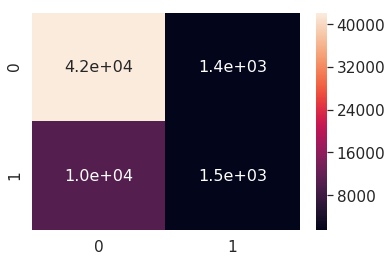

In [662]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [663]:
print(dtree_clf.stages[2])

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_07b24c1519d2) of depth 3 with 7 nodes


**RANDOM FOREST**

In [108]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Risk", featuresCol="Features", numTrees=10)

In [109]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [110]:
rf_model = pipeline.fit(train)

# Make predictions.
start = time.time()
predictions = rf_model.transform(test)
print(time.time() - start)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Risk", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

0.12632179260253906
Test Error = 0.213318


In [725]:
y_true = predictions.select(['Risk']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     43540
         1.0       0.52      0.13      0.21     12000

   micro avg       0.79      0.79      0.79     55540
   macro avg       0.66      0.55      0.54     55540
weighted avg       0.74      0.79      0.73     55540



**Linear SVM**

In [123]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=100, regParam=0.001, tol=1e-4)

In [124]:
# Fit the model
lsvcModel = lsvc.fit(train)

print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

Coefficients: [0.0004973249817595177,-0.0,1.9994445160741543]
Intercept: -0.9630889684477062


In [125]:
import time 

start = time.time()
predictions = lsvcModel.transform(test)
print(time.time()-start)

0.054080963134765625


In [126]:
predictions.count()

55818

In [127]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [128]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88     43785
           1       0.53      0.13      0.21     12033

   micro avg       0.79      0.79      0.79     55818
   macro avg       0.67      0.55      0.54     55818
weighted avg       0.74      0.79      0.73     55818



In [713]:
predictions.head(1)

[Row(Gender='0', Alcohol='0', Belts='0', Gender_INT=0, Alcohol_INT=0, Belts_INT=0, label_INT=0, label=0, features=SparseVector(3, {}), rawPrediction=DenseVector([1.0035, -1.0035]), prediction=0.0)]

Exception ignored in: <bound method JavaModelWrapper.__del__ of <pyspark.mllib.evaluation.BinaryClassificationMetrics object at 0x7f0ded274d68>>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/mllib/common.py", line 142, in __del__
    self._sc._gateway.detach(self._java_model)
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'


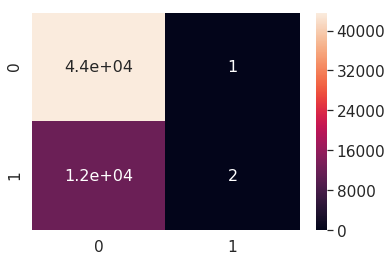

In [714]:
cm = confusion_matrix(y_true, y_pred)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

**Naive Bayes**

In [741]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
model = nb.fit(train)

# select example rows to display.
start = time.time()
predictions = model.transform(test)
print(time.time() - start)
# predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = " + str(accuracy))

0.03185081481933594
Test Accuracy = 0.7839575081022686


In [742]:
predictions.count()

55540

In [716]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     43568
           1       0.00      0.00      0.00     12049

   micro avg       0.78      0.78      0.78     55617
   macro avg       0.39      0.50      0.44     55617
weighted avg       0.61      0.78      0.69     55617



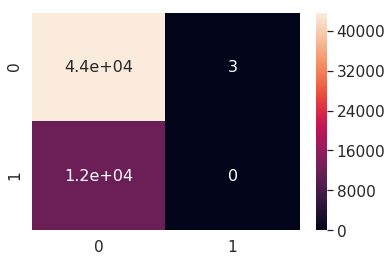

In [717]:
cm = confusion_matrix(y_true, y_pred)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()